### Wrangling & Analyzing Twitter Data (WeRateDogs Project)
by Ismail Osman<br>
June 22, 2018<br>

**Introduction**

In this project I will be wrangling the the tweet archive of Twitter user @dog_rates in a Jupyter Notebook, 
then showcase it through analysis and visualizations using Python (and its libraries). 


In [253]:
#import all modules
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
%matplotlib inline

### Data Gathering

In [254]:
# Read the twitter_archive_enhanced.csv file and 
df = pd.read_csv("twitter-archive-enhanced.csv", encoding = 'utf-8')

In [255]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [256]:
predictions = pd.read_csv("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv", sep="\t")
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [257]:
#Importing libraries
import tweepy
from tweepy import OAuthHandler
import json
import csv
import sys
import os
import time

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# Instructions for registering Twitter app and generating access tokens:
# https://www.slickremix.com/docs/how-to-get-api-keys-and-tokens-for-twitter/
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = "DizjiQU8gJJUX6EFwqAUJcBwB"
consumer_secret = "RECntBzrT2DD4jw4V1RNEThCW5WHJodjewRqIDzfEtISZViZhD"
access_token = "276819253-F2FigwLYFpoJzWNDH4KQLi7B0ccYan7YG37zx8Gj"
access_secret = "z87BR7ulhyAt63aS7CWwsuL7amVTisXn77htoZRaplGXy"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('data/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start) 
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1281: 708834316713893888
Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
13

Success
1530: 690248561355657216
Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
15

Success
1779: 677895101218201600
Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
18

Success
2028: 671874878652489728
Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
20

2277: 667443425659232256
Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 6668

### Data 
* Retweet count
* Favorite/like count
* Hashtags
* Number of followers at time of tweet
* Number of replies to tweet

In [258]:
tweet_json = []

# read in the json file line by line into a list
with open("data/tweet_json.txt") as file:
    for line in file:
        tweet_json.append(json.loads(line))

In [259]:
tweet_json[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [260]:
# create a data frame containing the relevant api data
api_data = pd.DataFrame({'tweet_id': [i["id_str"] for i in tweet_json], 
     'retweet_count': [i["retweet_count"] for i in tweet_json], 
     'favorite_count': [i["favorite_count"] for i in tweet_json], 
     'hashtags': [i["entities"]["hashtags"] for i in tweet_json]})

## Data Assessing 

In [261]:
df_clean = df.copy()
api_data_clean = api_data.copy()
predictions_clean = predictions.copy()

In [262]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [263]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [264]:
api_data_clean.head(10)

,tweet_id,retweet_count,favorite_count,hashtags
0,892420643555336193,8218,37718,[]
1,892177421306343426,6077,32387,[]
2,891815181378084864,4019,24387,[]
3,891689557279858688,8364,41033,[]
4,891327558926688256,9078,39219,"[{'text': 'BarkWeek', 'indices': [129, 138]}]"
5,891087950875897856,3007,19714,"[{'text': 'BarkWeek', 'indices': [129, 138]}]"
6,890971913173991426,1989,11530,[]
7,890729181411237888,18262,63599,[]
8,890609185150312448,4134,27096,"[{'text': 'BarkWeek', 'indices': [113, 122]}]"
9,890240255349198849,7140,31082,[]


In [265]:
predictions_clean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [266]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [267]:
predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg                                            2
https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg    2
https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg                                            2
https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg                                            2
https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg                                            2
https://pbs.twimg.com/media/Ck2d7tJWUAEPTL3.jpg                                            2
https://pbs.twimg.com/media/CvJCabcWgAIoUxW.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/817423809049493505/pu/img/5OFW0yueFu9oTUiQ.jpg    2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg                       

#### Twitter Json

### Quality Issues:
#### archive and api data
* Both datasets still contain non-original tweets and tweets without images

#### More quality issues should become more apparent after data tidied; currently difficult to assess. 
### Tidiness Issues:

#### Archive data

* Some tweet_ids have repeated jpg_url
* Time of day tweet sent difficult to analyze, as not in own column
* Delete columns that won't be used for analysis


## Data Cleaning 

### Action 
* Remove all retweets and tweets without images.

In [268]:
# keep only tweets that are not retweets
df_clean = df[df.retweeted_status_id.isnull()]

# tweets without expanded url's don't have images
df_clean = df[~df.expanded_urls.isnull()]

In [269]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [270]:
df2_clean = df_clean.copy()
images_clean = predictions.copy()
api_data_clean_2 = api_data_clean.copy()

In [271]:
#converting from float to integers 
df2_clean['in_reply_to_status_id'] = pd.to_numeric(df2_clean['in_reply_to_status_id'])
df2_clean['retweeted_status_id'] = pd.to_numeric(df2_clean['retweeted_status_id'])
df2_clean['retweeted_status_user_id'] = pd.to_numeric(df2_clean['retweeted_status_user_id'])

In [272]:
#converting from object to Datetime 
df2_clean['retweeted_status_timestamp'] = pd.to_datetime(df2_clean['retweeted_status_timestamp'])
df2_clean['timestamp'] = pd.to_datetime(df2_clean['timestamp'])

In [273]:
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2297 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2297 non-null datetime64[ns]
source                        2297 non-null object
text                          2297 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2297 non-null int64
rating_denominator            2297 non-null int64
name                          2297 non-null object
doggo                         2297 non-null object
floofer                       2297 non-null object
pupper                        2297 non-null object
puppo                         2297 non-null object
dtypes: datetime

In [274]:
#keep original ratings (no retweets) that have images
df2_clean = df2_clean[pd.isnull(df2_clean['retweeted_status_user_id'])]

In [275]:
print(sum(df2_clean.retweeted_status_user_id.value_counts()))

0


In [276]:
#Delete columns that won't be used for analysis
df2_clean = df2_clean.drop(['source',
                                     'in_reply_to_status_id',
                                     'in_reply_to_user_id',
                                     'retweeted_status_id',
                                     'retweeted_status_user_id', 
                                     'retweeted_status_timestamp', 
                                     'expanded_urls'], 1)

In [277]:
df2_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


In [278]:
#combining dog types into one single column
df2_clean = pd.melt(df2_clean, id_vars=['tweet_id',                                          
                                                    'timestamp',
                                                    'text',
                                                    'rating_numerator',
                                                    'rating_denominator',
                                                    'name'],
                    var_name='dogs', value_name='dogs_type')

#drop dogs
df2_clean =df2_clean.drop('dogs', 1)

#Sort by dogs_type then drop duplicated based on tweet_id except the last occurrence
df2_clean = df2_clean.sort_values('dogs_type').drop_duplicates(subset='tweet_id',keep='last')

In [279]:
df2_clean['dogs_type'].value_counts()

None       1779
pupper      232
doggo        72
puppo        24
floofer      10
Name: dogs_type, dtype: int64

In [280]:
# Breaking timestamp into separate day,month,and year
df2_clean['year'] = df2_clean['timestamp'].dt.year
df2_clean['month'] = df2_clean['timestamp'].dt.month
df2_clean['day'] = df2_clean['timestamp'].dt.day
df2_clean = df2_clean.drop('timestamp', 1)

In [281]:
df2_clean['rating'] = df2_clean['rating_numerator'] / df2_clean['rating_denominator']
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 2041 to 6878
Data columns (total 10 columns):
tweet_id              2117 non-null int64
text                  2117 non-null object
rating_numerator      2117 non-null int64
rating_denominator    2117 non-null int64
name                  2117 non-null object
dogs_type             2117 non-null object
year                  2117 non-null int64
month                 2117 non-null int64
day                   2117 non-null int64
rating                2117 non-null float64
dtypes: float64(1), int64(6), object(3)
memory usage: 181.9+ KB


#### Images cleaning

In [282]:
images_clean = images_clean.drop_duplicates(subset=['jpg_url'], keep='last')

In [283]:
sum(images_clean['jpg_url'].duplicated())

0

In [284]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2009 non-null int64
jpg_url     2009 non-null object
img_num     2009 non-null int64
p1          2009 non-null object
p1_conf     2009 non-null float64
p1_dog      2009 non-null bool
p2          2009 non-null object
p2_conf     2009 non-null float64
p2_dog      2009 non-null bool
p3          2009 non-null object
p3_conf     2009 non-null float64
p3_dog      2009 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


In [285]:
#Create 1 column for image prediction and 1 column for confidence level
dog_type = []
confidence_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def image(images_clean):
    if images_clean['p1_dog'] == True:
        dog_type.append(images_clean['p1'])
        confidence_list.append(images_clean['p1_conf'])
    elif images_clean['p2_dog'] == True:
        dog_type.append(images_clean['p2'])
        confidence_list.append(images_clean['p2_conf'])
    elif images_clean['p3_dog'] == True:
        dog_type.append(images_clean['p3'])
        confidence_list.append(images_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

#series objects having index the image_prediction_clean column.        
images_clean.apply(image, axis=1)

#create new columns
images_clean['dog_type'] = dog_type
images_clean['confidence_list'] = confidence_list

In [286]:
#drop rows that has prediction_list with "error"
images_clean = images_clean[images_clean['dog_type'] != 'Error']

In [287]:
# Delete columns that will not be used for analysis
images_clean = images_clean.drop(['img_num', 'p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

In [288]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id           1691 non-null int64
jpg_url            1691 non-null object
dog_type           1691 non-null object
confidence_list    1691 non-null object
dtypes: int64(1), object(3)
memory usage: 66.1+ KB


#### api_data_clean cleaning

In [289]:
api_data_clean_2['tweet_id'].drop_duplicates

<bound method Series.drop_duplicates of 0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
5       891087950875897856
6       890971913173991426
7       890729181411237888
8       890609185150312448
9       890240255349198849
10      890006608113172480
11      889880896479866881
12      889665388333682689
13      889638837579907072
14      889531135344209921
15      889278841981685760
16      888917238123831296
17      888804989199671297
18      888554962724278272
19      888078434458587136
20      887705289381826560
21      887517139158093824
22      887473957103951883
23      887343217045368832
24      887101392804085760
25      886983233522544640
26      886736880519319552
27      886680336477933568
28      886366144734445568
29      886267009285017600
               ...        
2309    666411507551481857
2310    666407126856765440
2311    666396247373291520
2312    666373753744588802
2313    6663627

In [290]:
# Change tweet_id to type int64 in order to merge with the other two tables
api_data_clean_2['tweet_id'] = api_data_clean_2['tweet_id'].astype('int64')

In [291]:
#merging tables in to one dataset
df3_clean = pd.merge(api_data_clean_2, 
                      images_clean, 
                      how = 'left', on = ['tweet_id'])

#keep rows that have picture (jpg_url)
df3_clean = df3_clean[df3_clean['jpg_url'].notnull()]

#TEST
df3_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 1 to 2338
Data columns (total 7 columns):
tweet_id           1683 non-null int64
retweet_count      1683 non-null int64
favorite_count     1683 non-null int64
hashtags           1683 non-null object
jpg_url            1683 non-null object
dog_type           1683 non-null object
confidence_list    1683 non-null object
dtypes: int64(3), object(4)
memory usage: 105.2+ KB


In [292]:
df_merge = pd.merge(df3_clean, df2_clean, 
                      how = 'left', on = ['tweet_id'])

In [293]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 1682
Data columns (total 16 columns):
tweet_id              1683 non-null int64
retweet_count         1683 non-null int64
favorite_count        1683 non-null int64
hashtags              1683 non-null object
jpg_url               1683 non-null object
dog_type              1683 non-null object
confidence_list       1683 non-null object
text                  1623 non-null object
rating_numerator      1623 non-null float64
rating_denominator    1623 non-null float64
name                  1623 non-null object
dogs_type             1623 non-null object
year                  1623 non-null float64
month                 1623 non-null float64
day                   1623 non-null float64
rating                1623 non-null float64
dtypes: float64(6), int64(3), object(7)
memory usage: 223.5+ KB


## Storing, analyzing, and visualizing

In [294]:
#Store the clean DataFrame in a CSV file
df_merge.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

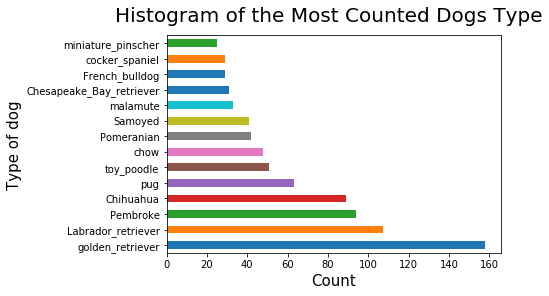

In [295]:
df_dog_type = df_merge.groupby('dog_type').filter(lambda x: len(x) >= 25)

df_dog_type['dog_type'].value_counts().plot(kind = 'barh')
plt.suptitle('Histogram of the Most Counted Dogs Type', fontsize=20)
plt.xlabel('Count',fontsize=15)
plt.ylabel('Type of dog',fontsize=15)

fig = plt.gcf() 
fig.savefig('output.png',bbox_inches='tight');

In [296]:
df_dog_type_mean = df_merge.groupby('dog_type').mean()

In [297]:
df_dog_type_mean.head()

,tweet_id,retweet_count,favorite_count,rating_numerator,rating_denominator,year,month,day,rating
dog_type,,,,,,,,,
Afghan_hound,8.171385e+17,5576.333333,7707.333333,8.000000,10.0,2016.500000,6.00,16.000000,0.800000
Airedale,7.184489e+17,1298.500000,5015.666667,9.833333,10.0,2015.583333,8.75,15.916667,0.983333
American_Staffordshire_terrier,7.597284e+17,2156.250000,8913.062500,10.312500,10.0,2016.187500,5.25,15.000000,1.031250
Appenzeller,7.939334e+17,1349.000000,6979.500000,11.000000,10.0,2016.500000,4.50,18.500000,1.100000
Australian_terrier,7.785921e+17,2881.000000,10595.000000,11.500000,10.0,2016.500000,3.50,7.000000,1.150000


In [298]:
df_dog_type_sorted = df_dog_type_mean['rating_numerator'].sort_values()
df_dog_type_sorted

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
Tibetan_terrier                 9.250000
dalmatian                       9.272727
Maltese_dog                     9.315789
Boston_bull                     9.416667
Saint_Bernard                   9.500000
Welsh_springer_spaniel          9.500000
Dandie_Dinmont                  9.571429
miniature_schnauzer             9.600000
Norwich_terrier                 9.600000
redbone                         9.666667
English_setter                  9.714286
Rhodesian_ridgeback             9.750000
Scottish_deerhound              9.750000
Irish_terrier                   9.800000
papillon                        9.833333
Airedale                        9.833333
Newfoundland                    9.857143
Mexican_hairless                9.857143
miniature_poodle                9.875000
miniature_pinscher              9.916667
Ibizan_

Text(0,0.5,'Count')

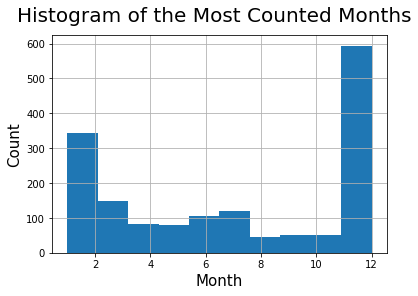

In [299]:
df_merge['month'].hist()
plt.suptitle('Histogram of the Most Counted Months', fontsize=20)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Count',fontsize=15)

#### Retweets and favorites based on the rating

Text(0,0.5,'Tweets Favorites')

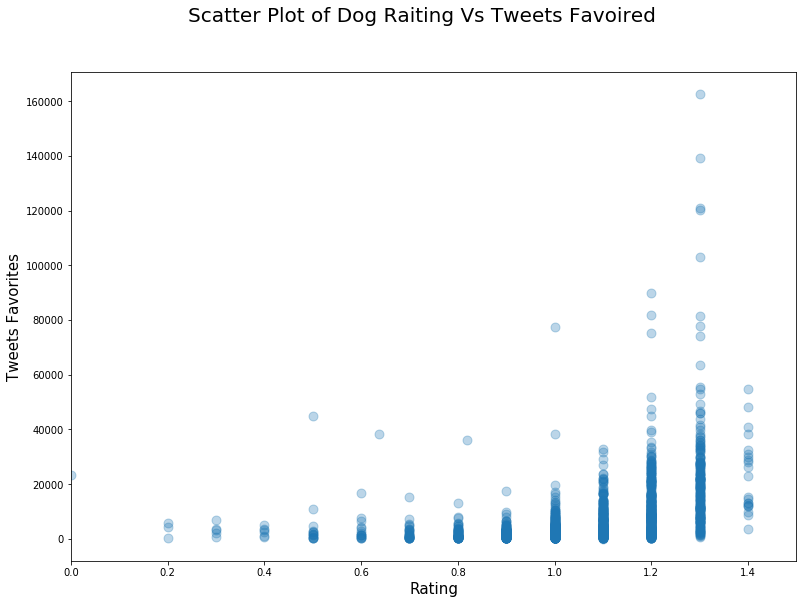

In [300]:
df_merge.plot(x='rating', y='favorite_count', kind='scatter', s= 80 ,alpha = .3, figsize = (13,9))
plt.xlim([0,1.5])
plt.suptitle('Scatter Plot of Dog Raiting Vs Tweets Favoired', fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.ylabel('Tweets Favorites',fontsize=15)

Text(0,0.5,'ReTweets')

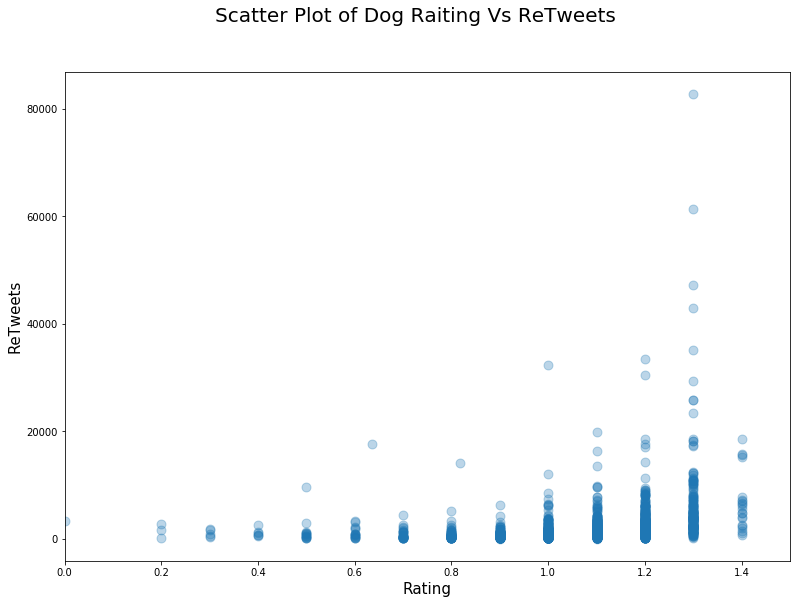

In [301]:
df_merge.plot(x='rating', y='retweet_count', kind='scatter',s= 80 ,alpha = .3, figsize = (13,9))
plt.xlim([0,1.5])
plt.suptitle('Scatter Plot of Dog Raiting Vs ReTweets', fontsize=20)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('ReTweets', fontsize=15)

In [302]:
#### Dog type rating

Text(0.5,0,'Dog Type')

<Figure size 432x288 with 0 Axes>

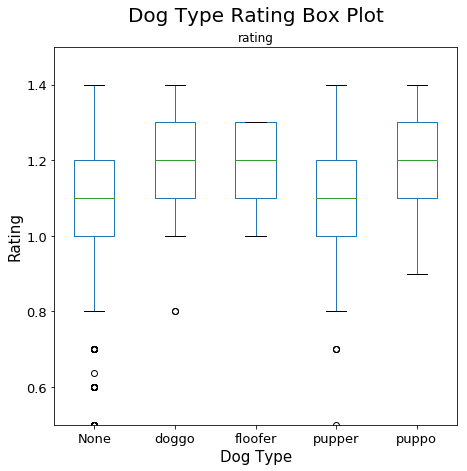

In [303]:
plt.figure()
df_merge[df_merge['dogs_type']!= ''].boxplot(column= ['rating'], by= ['dogs_type'], grid= False, fontsize = 13, figsize = (7,7))
plt.ylim(0.5,1.5)
plt.suptitle('Dog Type Rating Box Plot', fontsize=20)
plt.ylabel('Rating', fontsize=15)
plt.xlabel('Dog Type', fontsize=15)